# 1 Gathering

In [1]:
import pandas as pd
import requests

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, auth=('user', 'pass'))
filename = url.split('/')[-1]
with open(filename, mode='wb') as file:
        file.write(r.content)
predictions = pd.read_csv(filename, sep='\t')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [4]:
import tweepy
import json
import os

consumer_key = 'xxx'
consumer_secret = 'xxx'

#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

#api = tweepy.API(auth)

filename = 'tweet_json.txt'

In [5]:
#os.remove(filename)
#fails_list = []
#with open(filename, 'w') as file:
#    for i,tweet_id in enumerate(twitter_archive.tweet_id):
#        print(str(i) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print('Yess!')
#            json.dump(tweet._json, file)
#            file.write('\n')
#        except:
#            print('Fail')
#            fails_list.append(tweet_id)
#print(fails_list)

In [6]:
#json to dataframe with tweet ID, retweet count, and favorite count
cols = ['id','retweet_count','favorite_count','retweeted']
tweets_api = pd.DataFrame(columns = cols)
with open(filename) as file:
    Lines = file.readlines()
    for line in Lines:
        data = json.loads(line)
        tweets_api = tweets_api.append({s: data[s] for s in cols}, ignore_index=True)

In [7]:
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
id                877 non-null object
retweet_count     877 non-null object
favorite_count    877 non-null object
retweeted         877 non-null object
dtypes: object(4)
memory usage: 27.5+ KB


In [8]:
tweets_api.head()

,id,retweet_count,favorite_count,retweeted
0,892420643555336193,7426,35170,False
1,892177421306343426,5519,30446,False
2,891815181378084864,3645,22896,False
3,891689557279858688,7597,38465,False
4,891327558926688256,8179,36733,False


# 2 Assess

## 2.1 Tidiness

### 2.1.1 dog "stage" should be a single column

In [9]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### 2.1.2 Number of datasets

All three frames are orderes by tweet id, therefore it makes sense to combine them into a single dataframe

## 2.2 Quality

### 2.2.1  Ambiguous dog stage

In [10]:
# check how often more than one column is not 'NONE'
not_none = twitter_archive[['doggo','floofer','pupper','puppo']] != 'None'
not_none = not_none.astype(int)
(not_none.doggo + not_none.floofer + not_none.pupper + not_none.puppo).value_counts()

0    1976
1     366
2      14
dtype: int64

So in 14 cases two "stages" are set, we could define an order and select the higher "stage" in those cases

In [11]:
twitter_archive.retweeted_status_id.dtypes

dtype('float64')

### 2.2.2 Only dog ratings
We only want dogs, if none of the classifier predictions is dog we drop the tweet

In [12]:
predictions[(predictions.p1_dog == False) & (predictions.p2_dog == False) & (predictions.p3_dog == False)].shape[0]

324

### 2.2.3 Expanded URL not from twitter

In [13]:
matches = twitter_archive.expanded_urls.str.match('https://twitter.com/').values.astype(bool)
twitter_archive.expanded_urls[matches != True]

6       https://gofundme.com/ydvmve-surgery-for-jax,ht...
27      https://www.gofundme.com/mingusneedsus,https:/...
73      https://www.gofundme.com/3yd6y1c,https://twitt...
75      https://www.gofundme.com/3yd6y1c,https://twitt...
97      https://www.gofundme.com/help-my-baby-sierra-g...
98      https://www.gofundme.com/help-my-baby-sierra-g...
114     https://www.gofundme.com/help-fix-codys-torn-a...
124     https://www.gofundme.com/3ti3nps,https://twitt...
126     https://www.gofundme.com/3ti3nps,https://twitt...
146     https://www.gofundme.com/helpquinny,https://tw...
150     https://www.gofundme.com/helpquinny,https://tw...
159     https://www.gofundme.com/help-lorenzo-beat-can...
161     https://www.gofundme.com/help-lorenzo-beat-can...
177     https://www.gofundme.com/meeko-needs-heart-sur...
204     http://www.gofundme.com/bluethewhitehusky,http...
205     https://www.gofundme.com/bennys-medical-bills,...
233     https://www.gofundme.com/help-save-rontu,https...
237     https:

### 2.2.4 Name extraction shows errors
The names are often 'None', other unexpected names: 'the', 'a', 'an', 'very', 'just'

In [14]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
Toby           7
Daisy          7
an             7
Bailey         7
Buddy          7
Dave           6
Stanley        6
Milo           6
Koda           6
Leo            6
Jax            6
Rusty          6
Jack           6
Bella          6
Oscar          6
Scout          6
Louis          5
            ... 
Todo           1
Shnuggles      1
Jim            1
Dotsy          1
Ralphy         1
Akumi          1
Comet          1
Socks          1
Sonny          1
Josep          1
Tom            1
Danny          1
Jimbo          1
Glenn          1
Godzilla       1
Tedders        1
Jeb            1
Pete           1
Yoda           1
such           1
BeBe           1
Bobb           1
Aldrick        1
Bubba          1
Hero           1
Bloo           1
Anthony        1
Huxley        

### 2.2.5 Properties from json are all strings

In [15]:
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 4 columns):
id                877 non-null object
retweet_count     877 non-null object
favorite_count    877 non-null object
retweeted         877 non-null object
dtypes: object(4)
memory usage: 27.5+ KB


count columns should be int, retweeted bool

### 2.2.6 Consistent prediction label format
Not all classifications start with a captial letter

In [16]:
predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
web_site                      19
Cardigan                      19
teddy                         18
Eskimo_dog                    18
beagle                        18
Shetland_sheepdog             18
Maltese_dog                   18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
kuvasz                        16
Italian_greyhound             16
          

### 2.2.7 Same Denominator
Almost all ratings have a denominator of 10, therefore it makes sense to filter the few remaining tweets to have the same basis for all remaining tweets

In [17]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### 2.2.8 Source values should be cleaned

In [18]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

Can be simplified to 'iphone', 'vine', 'web client', 'tweetdeck' for readability

Only 2075 images are available

# 3 Cleaning

In [19]:
# copy the archive to keep the original archice
twitter_archive_master = twitter_archive.copy()

### 3.1.1 and 2.1.1 dog "stage" should be a single unabiguous column

In [20]:
%%capture
not_none = twitter_archive[['doggo','floofer','pupper','puppo']] != 'None'
not_none = not_none.astype(int)
# store double categorized to set to None later
reset = (not_none.doggo + not_none.floofer + not_none.pupper + not_none.puppo) > 1
# concatenate strings and remove None's
twitter_archive_master['stage'] = twitter_archive_master.doggo + twitter_archive_master.floofer + twitter_archive_master.pupper + twitter_archive_master.puppo
twitter_archive_master.stage = twitter_archive_master.stage.str.replace('None','')
# change empty stages to None again
twitter_archive_master.stage[twitter_archive_master.stage == ''] = 'None'
# now reset the double stages
twitter_archive_master.stage[reset] = 'None'

In [21]:
# drop individual columns
twitter_archive_master.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace=True)

In [22]:
twitter_archive_master.stage.value_counts()

None       1990
pupper      245
doggo        83
puppo        29
floofer       9
Name: stage, dtype: int64

In [23]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
stage                         2356 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


### 3.1.2 Number of datasets

In [24]:
# join archive with network predictions (so all ids have an image)
twitter_archive_master = twitter_archive_master.join(predictions.set_index('tweet_id'),on='tweet_id',how='inner')

In [25]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
stage                         2075 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null int64
p1                            2075 non-null object
p1_conf                       2075 n

In [26]:
# merge api information
twitter_archive_master.columns
twitter_archive_master = twitter_archive_master.join(tweets_api.set_index('id'),on='tweet_id',how='inner')

### 3.2.2 Only dog ratings

In [27]:
ind = twitter_archive_master[(twitter_archive_master.p1_dog == False) & (twitter_archive_master.p2_dog == False) & (twitter_archive_master.p3_dog == False)].index
twitter_archive_master.drop(ind, axis = 0, inplace=True)
assert twitter_archive_master[(twitter_archive_master.p1_dog == False) & (twitter_archive_master.p2_dog == False) & (twitter_archive_master.p3_dog == False)].shape[0] == 0

In [28]:
twitter_archive_master.retweeted_status_user_id.dtypes, twitter_archive_master.retweeted_status_id.dtypes

(dtype('float64'), dtype('float64'))

### 3.2.3 Expanded URL not from twitter

In [29]:
matches = twitter_archive_master.expanded_urls.str.match('https://twitter.com/').values.astype(bool)
twitter_archive_master.expanded_urls[matches != True] = ''

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 3.2.4 Name extraction shows errors
The names are often 'None', other unexpected names: 'the', 'a', 'an', 'very', 'just'

In [30]:
a = pd.Series(['a','an','just','very','None','Lukas','Bla'])
a.str.replace('(^None$|^an*$|^just$|^very$|^the$)','',regex=True)
a

0        a
1       an
2     just
3     very
4     None
5    Lukas
6      Bla
dtype: object

In [31]:
twitter_archive_master.name = twitter_archive_master.name.str.replace('^None$|^[a-z].*$','',regex=True)

In [32]:
twitter_archive_master.name.value_counts()

               115
Tucker           6
Penny            6
Charlie          5
Bo               5
Stanley          4
Daisy            4
Winston          4
Loki             4
Dave             4
Rusty            4
Cooper           4
Boomer           3
Toby             3
Jeffrey          3
Jack             3
Leo              3
Koda             3
Paisley          3
Finn             3
Bruce            3
Bear             3
Alfie            3
Lucy             3
Zeke             3
Scout            3
Oakley           3
Clark            3
Winnie           3
Lola             3
              ... 
Franklin         1
Glenn            1
Beebop           1
Dawn             1
Jax              1
Binky            1
Solomon          1
Halo             1
Sephie           1
Wafer            1
Ash              1
Monkey           1
Chevy            1
Mack             1
Shikha           1
Arya             1
Augie            1
Kota             1
Zooey            1
Milky            1
Lily             1
Chubbs      

### 3.2.5 Properties from json are all strings

In [33]:
twitter_archive_master[['retweet_count','favorite_count']] = twitter_archive_master[['retweet_count','favorite_count']].astype(int)

In [34]:
twitter_archive_master['retweeted'] = twitter_archive_master['retweeted'].astype(bool)

In [35]:
twitter_archive_master[['retweet_count','favorite_count','retweeted']].dtypes

retweet_count     int64
favorite_count    int64
retweeted          bool
dtype: object

### 3.2.6 Consistent prediction label format
Not all classifications start with a captial letter

In [36]:
twitter_archive_master.p1 = twitter_archive_master.p1.str.capitalize()
twitter_archive_master.p2 = twitter_archive_master.p2.str.capitalize()
twitter_archive_master.p3 = twitter_archive_master.p3.str.capitalize()

In [37]:
twitter_archive_master.p1.values

array(['Chihuahua', 'Chihuahua', 'Paper_towel', 'Basset',
       'Chesapeake_bay_retriever', 'Appenzeller', 'Pomeranian',
       'Irish_terrier', 'Pembroke', 'Samoyed', 'French_bulldog',
       'Pembroke', 'French_bulldog', 'Golden_retriever', 'Whippet',
       'Golden_retriever', 'Golden_retriever', 'Siberian_husky',
       'French_bulldog', 'Basset', 'Pembroke', 'Mexican_hairless',
       'Samoyed', 'Chihuahua', 'Kuvasz', 'French_bulldog', 'Pug',
       'Blenheim_spaniel', 'Pug', 'Labrador_retriever', 'Malamute',
       'Italian_greyhound', 'Chow', 'Pug', 'Pembroke', 'German_shepherd',
       'Doberman', 'Golden_retriever', 'Chow', 'Golden_retriever',
       'Eskimo_dog', 'Labrador_retriever', 'Pembroke', 'Golden_retriever',
       'Web_site', 'Weimaraner', 'Saluki', 'Samoyed', 'Pembroke',
       'Golden_retriever', 'Chihuahua', 'Miniature_pinscher', 'Basset',
       'German_short-haired_pointer', 'English_springer', 'Tricycle',
       'Vizsla', 'Italian_greyhound', 'Basset', 'French

### 3.2.7 Same Denominator
Almost all ratings have a denominator of 10, therefore it makes sense to filter the few remaining tweets to have the same basis for all remaining tweets

In [38]:
ind = twitter_archive_master.query('rating_denominator != 10').index

twitter_archive_master.drop(ind, axis = 0, inplace = True)
assert twitter_archive_master.query('rating_denominator != 10').shape[0] == 0

### 3.2.8 Source values should be cleaned

In [39]:
twitter_archive_master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>    632
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      5
Name: source, dtype: int64

In [40]:
twitter_archive_master.source[twitter_archive_master.source.str.contains('iphone',regex=False)] = 'iphone'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
twitter_archive_master.source[twitter_archive_master.source.str.contains('Web Client',regex=False)] = 'web_client'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
twitter_archive_master.source.value_counts()

iphone        632
web_client      5
Name: source, dtype: int64

In [43]:
#You only want original ratings (no retweets) that have images

# 4 Test

We only want original ratings (no retweets) that have images:

In [44]:
assert twitter_archive_master.retweeted.any() == False
assert (twitter_archive_master.img_num > 0).all()

In [45]:
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

In [46]:
# properties of the final dataset
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637 entries, 1 to 899
Data columns (total 28 columns):
tweet_id                      637 non-null int64
in_reply_to_status_id         4 non-null float64
in_reply_to_user_id           4 non-null float64
timestamp                     637 non-null object
source                        637 non-null object
text                          637 non-null object
retweeted_status_id           53 non-null float64
retweeted_status_user_id      53 non-null float64
retweeted_status_timestamp    53 non-null object
expanded_urls                 637 non-null object
rating_numerator              637 non-null int64
rating_denominator            637 non-null int64
name                          637 non-null object
stage                         637 non-null object
jpg_url                       637 non-null object
img_num                       637 non-null int64
p1                            637 non-null object
p1_conf                       637 non-null float64
p

# 5 Insights & Visualization

## 5.1 Most of the tweets are uploaded with iphone

In [47]:
twitter_archive_master.query('source == "iphone"').shape[0] / twitter_archive_master.shape[0]

0.9921507064364207

99% of the tweets are uploaded via iphone

## 5.2 Most frequent dog breed 

In [48]:
twitter_archive_master.p1.value_counts().index[0]

'Golden_retriever'

# 5.3 Favourite Breeds

In [49]:
import matplotlib.pyplot as plt

In [50]:
# group by classification and calculate retweets & favourites means
p1_counts = twitter_archive_master[['p1','retweet_count','favorite_count']].groupby(['p1']).mean()

In [51]:
top8_retweet_value = p1_counts.retweet_count.sort_values()[-8]
top8_retweet = p1_counts.query('retweet_count >= @top8_retweet_value')

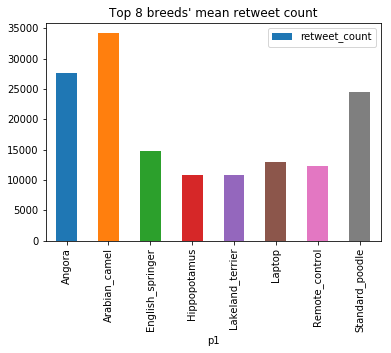

In [56]:
top8_retweet.plot.bar(y='retweet_count');
plt.title("Top 8 breeds' mean retweet count");
plt.savefig('top8retweet.png', bbox_inches = 'tight')

In [59]:
# same plot for favorite count
top8_fav_value = p1_counts.favorite_count.sort_values()[-8]
top8_fav = p1_counts.query('favorite_count >= @top8_fav_value')

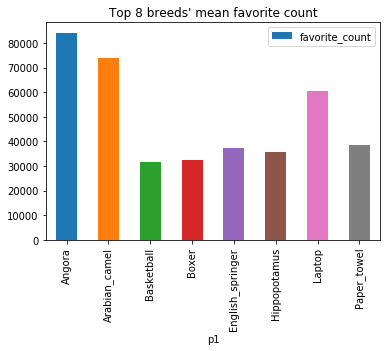

In [60]:
#import matplotlib.pyplot as plt
top8_fav.plot.bar(y='favorite_count');
plt.title("Top 8 breeds' mean favorite count");
plt.savefig('top8favorite.png', bbox_inches = 'tight')